# **Project Introduction**

## Dataset description

Estimation of HDB Resale Flats Pricing in Singapore using Machine Learning
The dataset is focused on the HDB resale transaction prices in Singapore. Housing Development Board (HDB) has published housing data containing 10 distinct types of metrics such as month registered for resale, town, flat types, etc. The data is published by the Singapore government and hence holds a high degree of reliability and accuracy.

## Motivation/Problem Statement


This project is crucial in addressing the rising demand for housing in the face of a growing population and escalating costs in land-scarce Singapore. With concerns about affordability on the rise, the project focuses on helping individuals estimate resale flat prices, enabling them to strategically plan and explore housing options that fit their financial constraints and specific criteria. We will be focusing on leveraging machine learning techniques to predict resale flat prices.


## Key Questions:

1. What are the primary factors affecting the price of resale flats in Singapore?
2. Which features should we use for our predictive model?
3. What are some limitations/biases that might occur in the predictive model?
4. Will the model be able to capture temporal trends in the market?
5. How will the model be affected by outliers that indicate high levels of risk?


By addressing these key questions, this project aims to provide a valuable tool for individuals in Singapore to better plan and navigate the complex housing market, ultimately helping them make more informed decisions when buying or selling resale flats.

# **Getting Started**

Clone the git repository into your local directory





git clone https://github.com/Cheenaswee/CS3244-Machines-That-Learn.git

# **Data Extraction, Collection & Preparation**

## Unzipping the Datasets.zip file

Running the code will extract the resale_data.csv into the Dataset folder


In [49]:
import os
import zipfile

zip_directory = r"..\CS3244-Machines-That-Learn\Dataset"
zip_file_path = os.path.join(zip_directory, "resale_flat.zip")
extract_to_directory = r"..\CS3244-Machines-That-Learn\Dataset"

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print("Error: Zip file does not exist")
    exit()

# Check if the extraction directory exists
if not os.path.exists(extract_to_directory):
    os.makedirs(extract_to_directory)
    print(f"Created extraction directory: {extract_to_directory}")

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)
    print("Extraction completed successfully.")



Extraction completed successfully.


# **Import Basic Libraries**

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import requests
import re

## Reading in Resale Flat Prices Data

Link to Data: https://www.kaggle.com/datasets/mikelll/singapore-housing-price-20172022

In [52]:
dataset = pd.read_csv(r"..\CS3244-Machines-That-Learn\Dataset\resale_flat.csv")


In [53]:
print(dataset)

          month        town  flat_type block        street_name storey_range  \
0       2017-01  ANG MO KIO     2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1       2017-01  ANG MO KIO     3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2       2017-01  ANG MO KIO     3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3       2017-01  ANG MO KIO     3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4       2017-01  ANG MO KIO     3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
...         ...         ...        ...   ...                ...          ...   
134163  2022-08      YISHUN     5 ROOM   850       YISHUN ST 81     01 TO 03   
134164  2022-08      YISHUN  EXECUTIVE   325        YISHUN CTRL     07 TO 09   
134165  2022-08      YISHUN  EXECUTIVE   355     YISHUN RING RD     07 TO 09   
134166  2022-08      YISHUN  EXECUTIVE   355     YISHUN RING RD     07 TO 09   
134167  2022-08      YISHUN  EXECUTIVE   643       YISHUN ST 61     10 TO 12   

        floor_area_sqm      flat_model 

## Convert 'flat_type' and 'flat_model' columns into numerical data

In [54]:
le_flat_type = LabelEncoder()
dataset['flat_type'] = le_flat_type.fit_transform(dataset['flat_type'])
le_flat_model = LabelEncoder()
dataset['flat_model'] = le_flat_model.fit_transform(dataset['flat_model'])

## Split the dataset into training and testing sets

In [55]:
X = dataset[['flat_type', 'flat_model', 'floor_area_sqm']]  
y = dataset['resale_price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Further split the training set into training and validation sets

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## Scatter plot between 'floor_area_sqm' and 'resale_price'

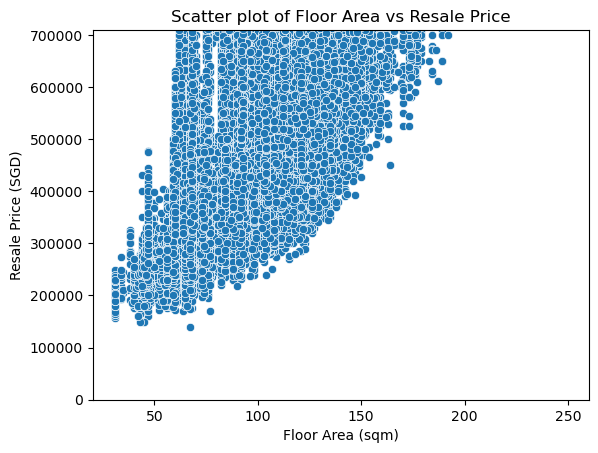

In [57]:
sns.scatterplot(x='floor_area_sqm', y='resale_price', data=dataset)
plt.title('Scatter plot of Floor Area vs Resale Price')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')

# Adjusting the limits of the y-axis
plt.ylim(0, dataset['resale_price'].max() * 0.5)  # Adjust multiplier as needed
plt.show()

## Scatter plot between 'flat_type' and 'resale_price'

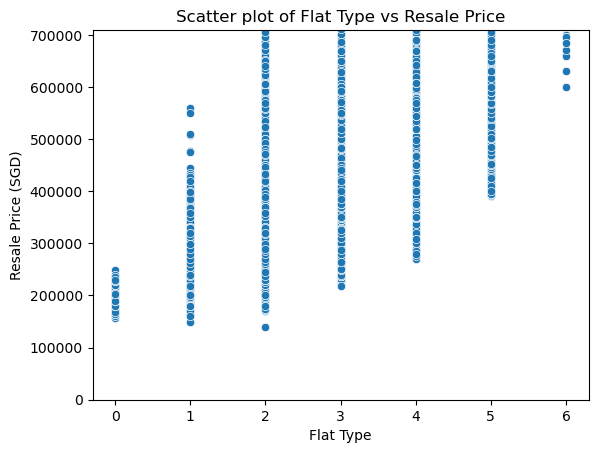

In [58]:
sns.scatterplot(x='flat_type', y='resale_price', data=dataset)
plt.title('Scatter plot of Flat Type vs Resale Price')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price (SGD)')

# Adjusting the limits of the y-axis
plt.ylim(0, dataset['resale_price'].max() * 0.5)  # Adjust multiplier as needed

plt.show()

## Scatter plot between 'flat_model' and 'resale_price'

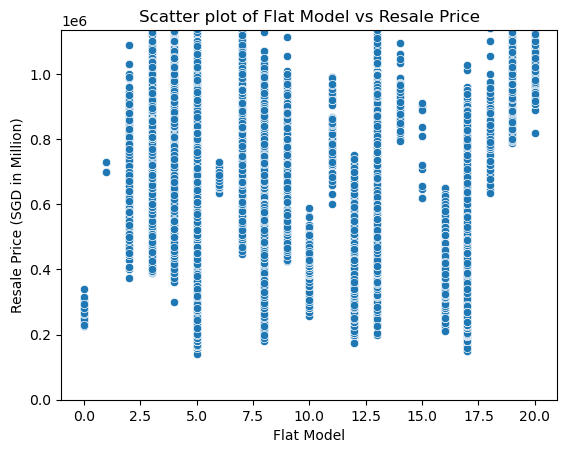

In [59]:
sns.scatterplot(x='flat_model', y='resale_price', data=dataset)
plt.title('Scatter plot of Flat Model vs Resale Price')
plt.xlabel('Flat Model')
plt.ylabel('Resale Price (SGD in Million)')

# Adjusting the limits of the y-axis
plt.ylim(0, dataset['resale_price'].max() * 0.8)  # Adjust multiplier as needed

plt.show()

## Correlation matrix

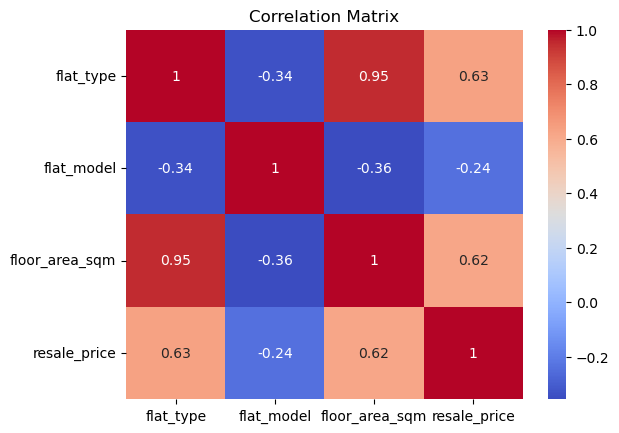

In [60]:
corr_matrix = dataset[['flat_type', 'flat_model', 'floor_area_sqm', 'resale_price']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# **Exploring Different Models with Data**

## Linear Regression

In [61]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Evaluate Linear Regression model
y_pred_linear = linear_model.predict(X_val)
mse_linear = mean_squared_error(y_val, y_pred_linear)
r2_linear = r2_score(y_val, y_pred_linear)

print("Linear Regression Results:")
print(f"Mean Squared Error: {mse_linear}")
print(f"R^2 Score: {r2_linear}")

Linear Regression Results:
Mean Squared Error: 15609851123.954845
R^2 Score: 0.4064110871426325


## Random Forest

In [62]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred_rf = random_forest_model.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest Results:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R^2 Score: {r2_rf}")

Random Forest Results:
Mean Squared Error: 10197103877.503803
R^2 Score: 0.6122392355393844


## Decision Trees

In [63]:
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train, y_train)

# Evaluate Decision Tree model
y_pred_dt = decision_tree_model.predict(X_val)
mse_dt = mean_squared_error(y_val, y_pred_dt)
r2_dt = r2_score(y_val, y_pred_dt)

print("\nDecision Tree Results:")
print(f"Mean Squared Error: {mse_dt}")
print(f"R^2 Score: {r2_dt}")


Decision Tree Results:
Mean Squared Error: 10209063638.32431
R^2 Score: 0.6117844469980265


## SVM